# Time Series with Statistics Method: SARIMAX

Collection of methods and models on how to make an analysis and prediction with SARIMAX method. Functions referred to **Time Series Forecasting in Pythin written by Marco Peixeiro (2022)** with several adjustments. All plug-and-play functions could be seen in fun_arma-family.py file. Methods used on this study is:

- SARIMAX: Seasonal Auto-Regressive Integrated Moving Average with Exogenous Variable
- Rolling Forecast: Step-by-step forecast, using SARIMAX

In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL

In [4]:
# hide the warning

import warnings
warnings.filterwarnings("ignore")

## Data Exploration

Data used in this study is the **Walmart Sales Dataset of 45 Stores** by Meaga Varsha Ramakrishnan. He made it available on his <a href='https://www.kaggle.com/datasets/varsharam/walmart-sales-dataset-of-45stores'>Kaggle page</a>. 

In [302]:
df = pd.read_csv('dataset/walmart-sales-dataset-of-45stores.csv',
                 parse_dates=['Date'],
                 infer_datetime_format=True)

df = df[df['Date'] < '2012-12-01 00:00:00']  # remove december as it is incomplete yet
df.index = df['Date']
df.drop('Date', axis=1, inplace=True)

display(df.head(5))
print('length of the dataframe:', len(df))

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-05-02,1,1643690.90,0,42.31,2.572,211.096358,8.106
2010-12-02,1,1641957.44,1,38.51,2.548,211.242170,8.106
2010-02-19,1,1611968.17,0,39.93,2.514,211.289143,8.106
2010-02-26,1,1409727.59,0,46.63,2.561,211.319643,8.106
2010-05-03,1,1554806.68,0,46.50,2.625,211.350143,8.106


length of the dataframe: 6390


In [254]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6390 entries, 2010-05-02 to 2012-10-26
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6390 non-null   int64  
 1   Weekly_Sales  6390 non-null   float64
 2   Holiday_Flag  6390 non-null   int64  
 3   Temperature   6390 non-null   float64
 4   Fuel_Price    6390 non-null   float64
 5   CPI           6390 non-null   float64
 6   Unemployment  6390 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 399.4 KB


In [303]:
# data for 2012 is not complete yet
# still need to collect for about 2 months, november and december

print('earliest date:', df.index.min())
print('latest date:', df.index.max())

earliest date: 2010-01-10 00:00:00
latest date: 2012-11-05 00:00:00


In [304]:
# aggregate the data by week

weekly_df = df.groupby('Date').agg({'Weekly_Sales': 'mean',
                                    'Holiday_Flag': 'max',
                                    'Temperature': 'mean',
                                    'Fuel_Price': 'mean',
                                    'CPI': 'mean', 
                                    'Unemployment': 'mean'})

display(weekly_df.head(5))
print('length of the dataframe:', len(weekly_df))

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,
2010-01-10,9.386639e+05,0,69.868000,2.734333,168.354706,8.475289
2010-02-04,1.120530e+06,0,53.120889,2.827333,167.789036,8.497711
2010-02-07,1.087055e+06,0,77.133333,2.793511,167.982101,8.428578
2010-02-19,1.072822e+06,0,37.719778,2.672067,167.871686,8.619311
2010-02-26,9.770794e+05,0,39.243556,2.683933,167.909657,8.619311


length of the dataframe: 142


In [305]:
# groupby date, and group again by month
# to create a monthly data frame

monthly_df = df.groupby('Date').agg({'Weekly_Sales': 'mean',
                                     'Holiday_Flag': 'max',
                                     'Temperature': 'mean',
                                     'Fuel_Price': 'mean',
                                     'CPI': 'mean', 
                                     'Unemployment': 'mean'})

monthly_df = round(monthly_df, 3)
monthly_df = monthly_df.groupby(pd.Grouper(freq='M')).agg({'Weekly_Sales': 'mean',
                                                           'Holiday_Flag': 'max',
                                                           'Temperature': 'mean',
                                                           'Fuel_Price': 'mean',
                                                           'CPI': 'mean', 
                                                           'Unemployment': 'mean'})

monthly_df['Month'] = monthly_df.index.month_name()
monthly_df['Month_code'] = monthly_df.index.month
monthly_df.rename(columns={'Weekly_Sales': 'Monthly_Sales'}, inplace=True)

display(monthly_df.head(5))
print('length of the dataframe:', len(monthly_df))

,Monthly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Month,Month_code
Date,,,,,,,,
2010-01-31,9.386639e+05,0,69.86800,2.734000,168.355000,8.47500,January,1
2010-02-28,1.064372e+06,0,51.80450,2.744250,167.888250,8.54125,February,2
2010-03-31,1.034590e+06,0,54.11525,2.818250,168.124000,8.53550,March,3
2010-04-30,1.021177e+06,0,61.59425,2.868000,167.699750,8.49800,April,4
2010-05-31,1.039303e+06,0,54.49500,2.838167,167.881667,8.53450,May,5


length of the dataframe: 35


    Exploratory Data Analysis (EDA)

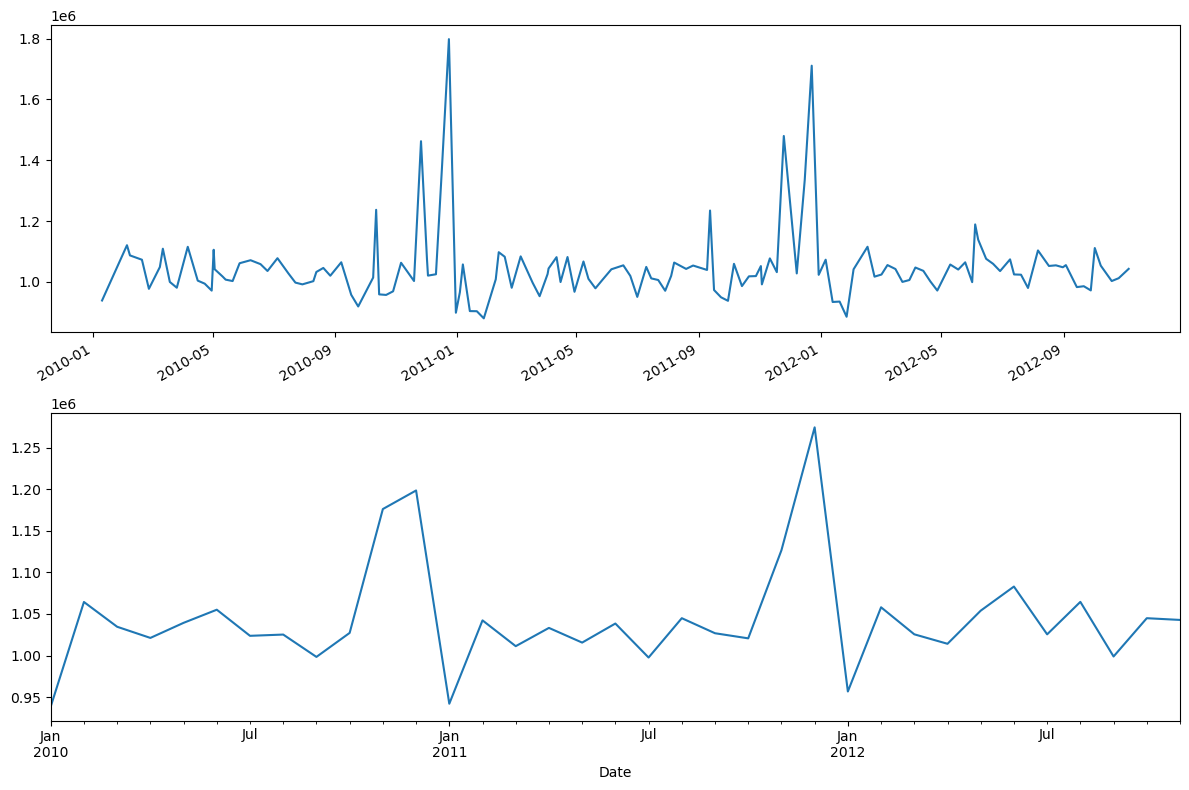

In [10]:
# plot all in one plot, grouping data by it's date
import matplotlib.dates as mdates

fig, axes = plt.subplots(2, figsize=(12,8))

weekly_df['Weekly_Sales'].plot(ax=axes[0], xlabel='')
monthly_df['Monthly_Sales'].plot(ax=axes[1])

plt.tight_layout()

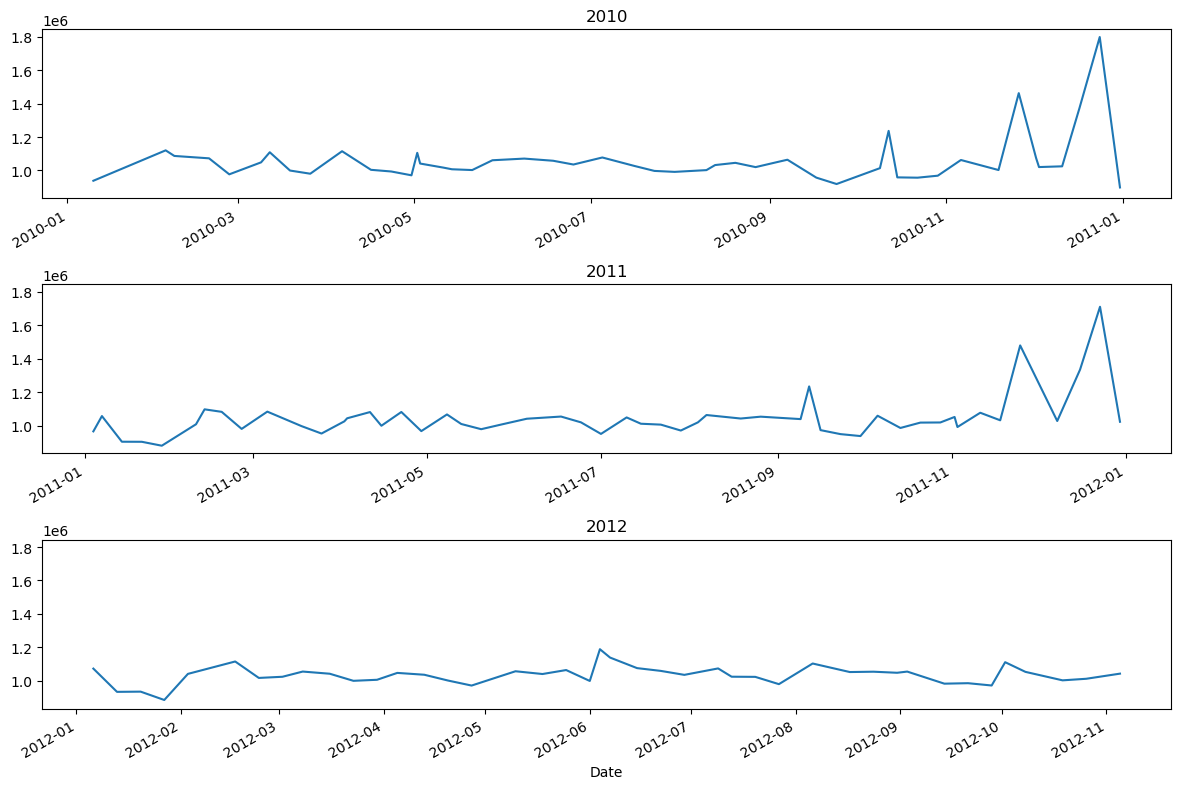

In [11]:
# taking a look only at years

fig, axes = plt.subplots(3, figsize=(12,8), sharey=True)

weekly_df[weekly_df.index < '01-01-2011']['Weekly_Sales'].plot(title='2010', ax=axes[0], xlabel='')
weekly_df[(weekly_df.index > '31-12-2010') & (weekly_df.index < '01-01-2012')]['Weekly_Sales'].plot(title='2011', ax=axes[1], xlabel='')
weekly_df[(weekly_df.index > '31-12-2011') & (weekly_df.index < '01-01-2013')]['Weekly_Sales'].plot(title='2012', ax=axes[2])

plt.tight_layout()

    Time series decomposition: Trend, Seasonal, Residuals

In [12]:
decomposition = STL(weekly_df['Weekly_Sales'], period=52).fit()

# print all of the composition

print('OBSERVED:\n', decomposition.observed[:3])        # real value
print('\nTREND:\n', decomposition.observed[:3])         # trend composition
print('\nSEASONAL:\n', decomposition.seasonal[:3])      # seasonality
print('\nRESIDUAL:\n', decomposition.resid[:3])         # residual

OBSERVED:
 Date
2010-01-10    9.386639e+05
2010-02-04    1.120530e+06
2010-02-07    1.087055e+06
Name: Weekly_Sales, dtype: float64

TREND:
 Date
2010-01-10    9.386639e+05
2010-02-04    1.120530e+06
2010-02-07    1.087055e+06
Name: Weekly_Sales, dtype: float64

SEASONAL:
 Date
2010-01-10   -149680.669276
2010-02-04     32650.679582
2010-02-07     45921.745323
Name: season, dtype: float64

RESIDUAL:
 Date
2010-01-10    28183.187666
2010-02-04    28050.595528
2010-02-07   -18363.166081
Name: resid, dtype: float64


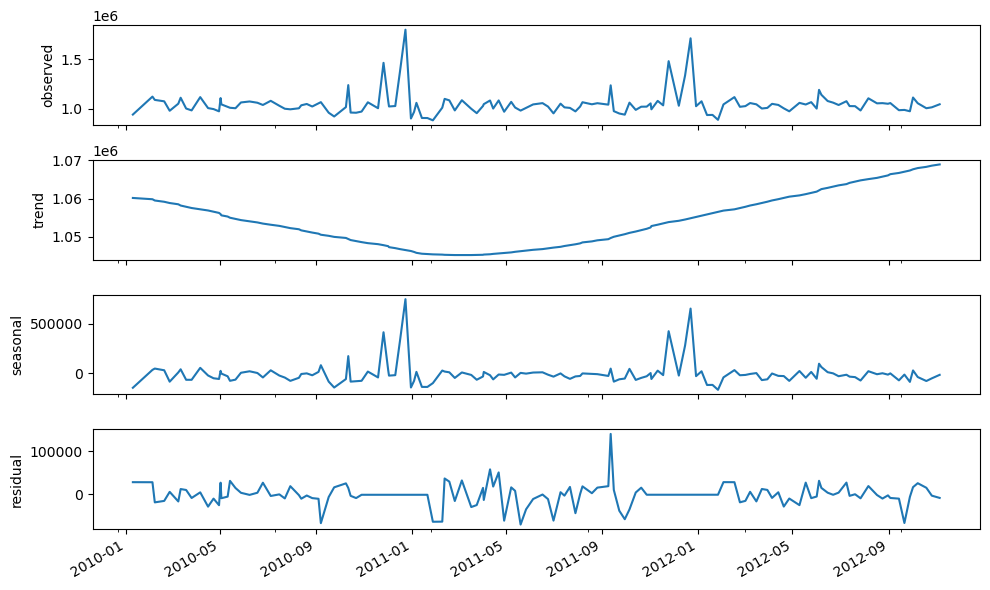

In [13]:
fig, axes = plt.subplots(4, figsize=(10,6), sharex=True)

decomposition.observed.plot(ax=axes[0], xlabel='', ylabel='observed')
decomposition.trend.plot(ax=axes[1], xlabel='', ylabel='trend')
decomposition.seasonal.plot(ax=axes[2], xlabel='', ylabel='seasonal')
decomposition.resid.plot(ax=axes[3], xlabel='', ylabel='residual')

plt.tight_layout()

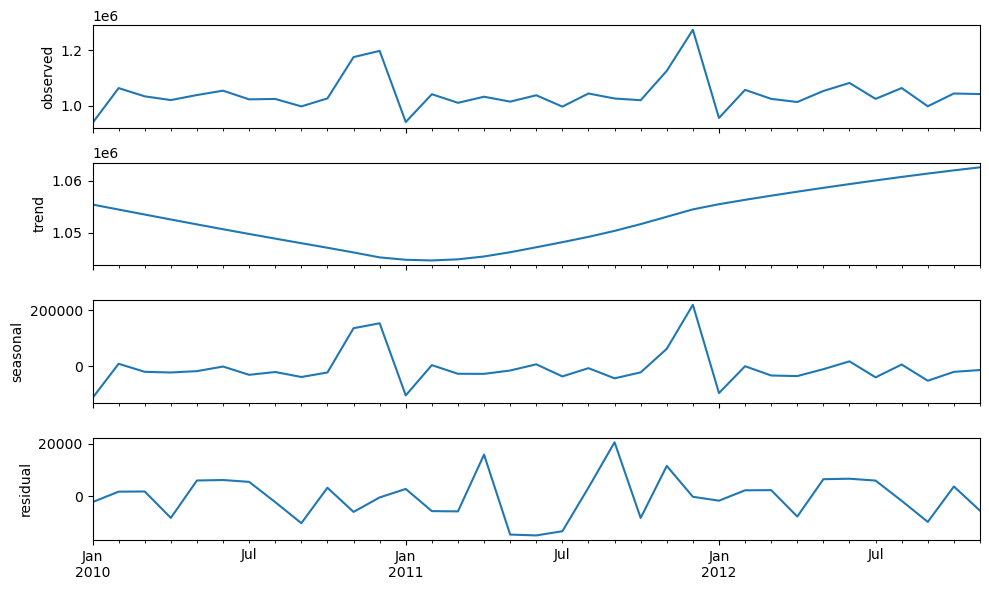

In [14]:
# decomposition for monthly data

decomposition = STL(monthly_df['Monthly_Sales'], period=12).fit()

fig, axes = plt.subplots(4, figsize=(10,6), sharex=True)

decomposition.observed.plot(ax=axes[0], xlabel='', ylabel='observed')
decomposition.trend.plot(ax=axes[1], xlabel='', ylabel='trend')
decomposition.seasonal.plot(ax=axes[2], xlabel='', ylabel='seasonal')
decomposition.resid.plot(ax=axes[3], xlabel='', ylabel='residual')

plt.tight_layout()

    Exploring Other Variables Available

In [15]:
# other time series data from the dataset
weekly_df[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].head(5)

,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,
2010-01-10,69.868000,2.734333,168.354706,8.475289
2010-02-04,53.120889,2.827333,167.789036,8.497711
2010-02-07,77.133333,2.793511,167.982101,8.428578
2010-02-19,37.719778,2.672067,167.871686,8.619311
2010-02-26,39.243556,2.683933,167.909657,8.619311


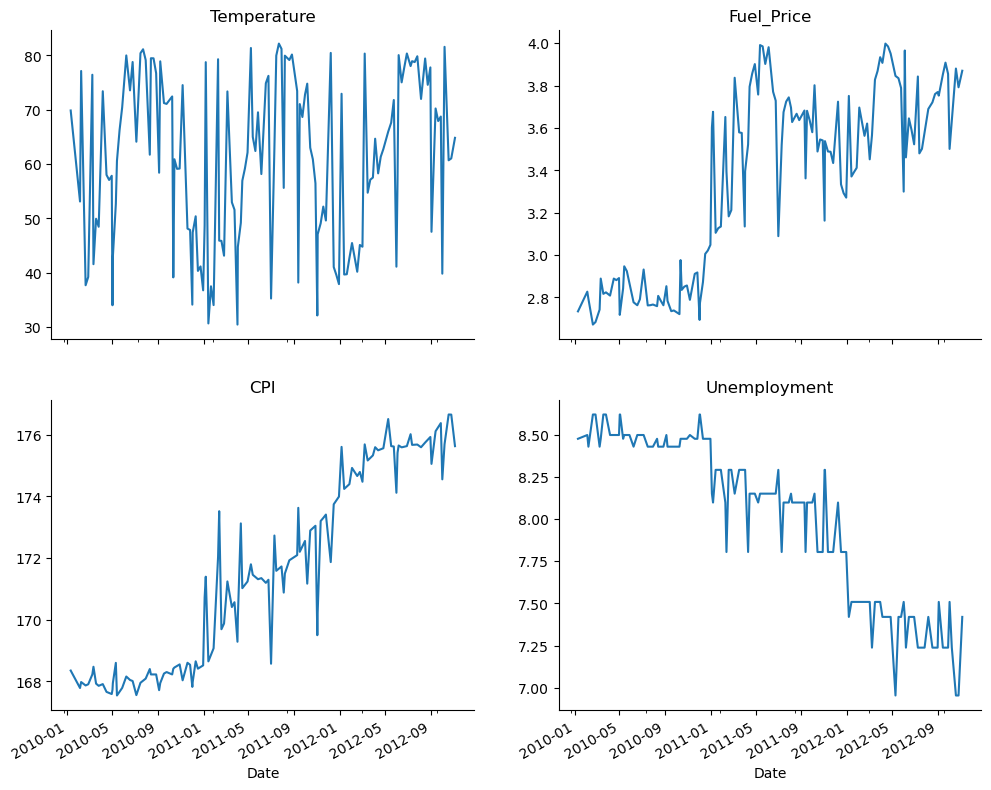

In [16]:
# weekly pattern

fig, axes = plt.subplots(2, 2, figsize=(12,10), sharex=True)
axe = axes.ravel()  # expand the axes, otherwise, will get 'numpy.ndarray' object has no attribute 'get_figure' 

for i, col in enumerate(['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']):
    weekly_df[col].plot(ax=axe[i], title=col, xlabel=None)
    
sns.despine()

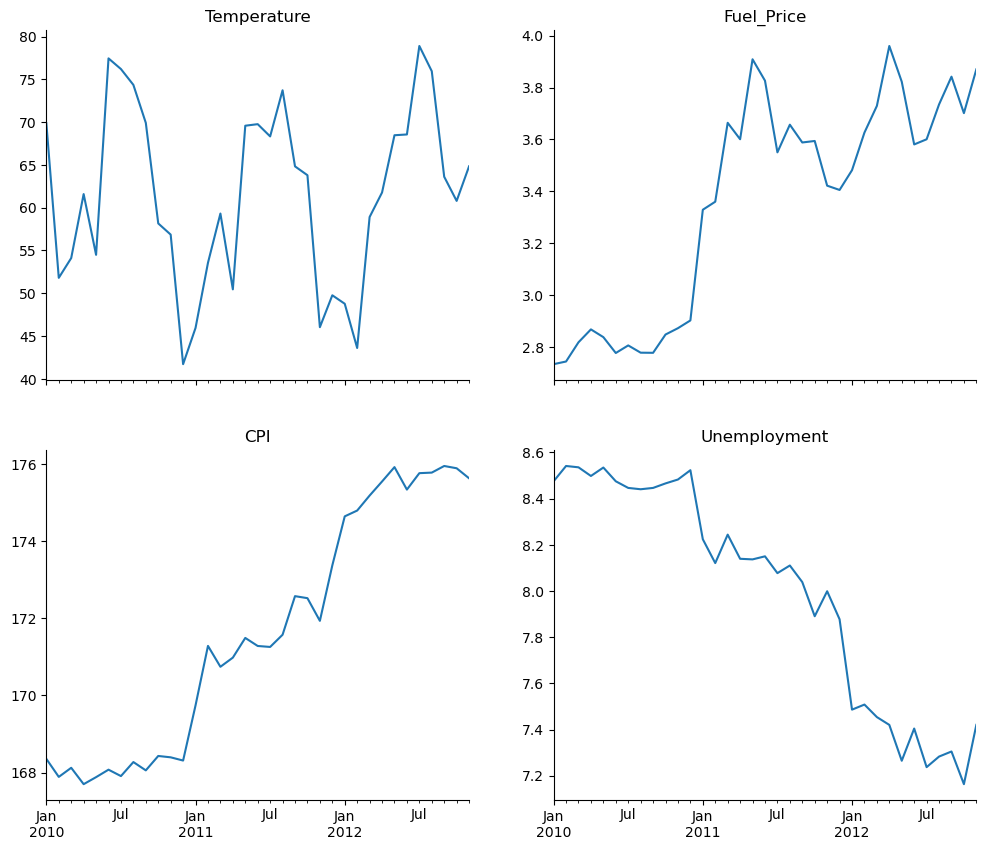

In [17]:
# monthly pattern

fig, axes = plt.subplots(2, 2, figsize=(12,10), sharex=True)
axe = axes.ravel()  # expand the axes, otherwise, will get 'numpy.ndarray' object has no attribute 'get_figure' 

for i, col in enumerate(['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']):
    monthly_df[col].plot(ax=axe[i], title=col, xlabel='')

sns.despine()

# Seasonal Auto-Regressive Integrated Moving Average with Exogenous Variables (SARIMAX)

SARIMA model, with additional exogenous variable (X). Thus, the equation would be:

$Y_{t} = SARIMA(p,d,q)(P,D,Q)_{m} + \sum_{i=1}^n \beta X_{t}^i$

For an easy notion, we can write it to be (SARIMAX) or SARIMAX(p, d, q)(P, D, Q)m.

## Step 1: Check the Data Stationarity

In [18]:
print('ADF statistic:', adfuller(weekly_df['Weekly_Sales'])[0])
print('ADF p-value:', adfuller(weekly_df['Weekly_Sales'])[1])

ADF statistic: -9.804211362757187
ADF p-value: 5.884889852358497e-17


In [19]:
print('ADF statistic:', adfuller(monthly_df['Monthly_Sales'])[0])
print('ADF p-value:', adfuller(monthly_df['Monthly_Sales'])[1])

ADF statistic: -4.360948775223099
ADF p-value: 0.0003478040463169166


    The data is already stationary, thus no need to apply any transformations

## Step 2: Grid Search, Minimize AIC by Adjusting Parameters

1. Looping the best parameters for the model
2. Fitting the best parameters to the model

    Function for SARIMAX optimization

In [20]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_SARIMAX(endog: Union[pd.Series, list], 
                     exog: Union[pd.Series, list],  # the difference, defining exog variable
                     order_list: list,
                     d: int,
                     D: int,
                     s: int
                     ) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog,
                            exog,
                            order=(order[0], d, order[1]),
                            seasonal_order=(order[2], D, order[3], s),
                            simple_differencing=False).fit(disp=False)
        except:
            continue
        
        aic = model.aic
        results.append([order, aic])
    
    result_df = pd.DataFrame(results)
    result_df.columns = ['p, q, P, Q', 'AIC']
    
    # sorting it by the smallest AIC value
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

    Check the monthly data first

In [48]:
target_month = monthly_df['Monthly_Sales']
exog_month = monthly_df[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']]

In [49]:
# train and test split
# train dataset by 80% of the data

target_month_train = target_month[:int((np.ceil(len(target_month) * 0.8)))]
exog_month_train = exog_month[:int((np.ceil(len(target_month) * 0.8)))]

In [31]:
# how to use the function

from itertools import product
import random

ps = range(0, 4, 1)     # define the range of p we want to check
qs = range(0, 4, 1)     # define the range of q we want to check
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

d = 0                   # how many differencing have we done
D = 0                   # how many differencing have we done
s = 12                  # frequency in a cycle

order_list = list(product(ps, qs, Ps, Qs))  # pairing all ps values with qs values
random.sample(order_list, 5)  # print 5 samples from order list


# initiating the grid search for SARIMAX

optimize_SARIMAX(endog=target_month_train,
                 exog=exog_month_train,
                 order_list=order_list,
                 d=d,
                 D=D,
                 s=s)

  0%|          | 0/256 [00:00<?, ?it/s]

,"p, q, P, Q",AIC
0,"(0, 0, 1, 0)",692.816836
1,"(0, 0, 0, 1)",703.965165
2,"(1, 0, 1, 0)",704.037490
3,"(0, 0, 1, 1)",704.306574
4,"(0, 0, 0, 2)",704.362300
...,...,...
251,"(3, 2, 2, 3)",721.402415
252,"(2, 2, 3, 3)",721.590837
253,"(3, 3, 3, 3)",722.805767
254,"(3, 2, 3, 3)",723.398415


For monthly data: **Optimum at SARIMAX(0, 0, 0)(1, 0, 0)12**

    Now check the weekly data

In [50]:
target_weekly = weekly_df['Weekly_Sales']
exog_weekly = weekly_df[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']]

In [51]:
# train and test split
# train dataset by 80% of the data

target_weekly_train = target_weekly[:int((np.ceil(len(target_weekly) * 0.8)))]
exog_weekly_train = exog_weekly[:int((np.ceil(len(exog_weekly) * 0.8)))]

In [34]:
# how to use the function

from itertools import product
import random

ps = range(0, 4, 1)     # define the range of p we want to check
qs = range(0, 4, 1)     # define the range of q we want to check
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

d = 0                   # how many differencing have we done
D = 0                   # how many differencing have we done
s = 52                  # frequency in a cycle

order_list = list(product(ps, qs, Ps, Qs))  # pairing all ps values with qs values
random.sample(order_list, 5)  # print 5 samples from order list


# initiating the grid search for SARIMAX

optimize_SARIMAX(endog=target_weekly_train,
                 exog=exog_weekly_train,
                 order_list=order_list,
                 d=d,
                 D=D,
                 s=s)

  0%|          | 0/256 [00:00<?, ?it/s]

,"p, q, P, Q",AIC
0,"(0, 0, 1, 0)",2983.654002
1,"(0, 0, 2, 0)",2990.609518
2,"(1, 0, 1, 0)",2996.319286
3,"(0, 1, 1, 0)",2996.882409
4,"(2, 0, 1, 0)",2997.472796
...,...,...
251,"(0, 3, 0, 0)",3020.484416
252,"(3, 0, 0, 0)",3020.557226
253,"(3, 1, 0, 0)",3020.797540
254,"(1, 3, 0, 0)",3021.208207


For weekly data: **Optimum at SARIMAX(0, 0, 0)(1, 0, 0)52**

## Step 4: Fitting the Model

### Model for Monthly Data

In [52]:
# define the test data for monthly model
# test dataset by 20% of the data

target_month_test = target_month.tail(len(target_month) - int((np.ceil(len(target_month) * 0.8))))
exog_month_test = exog_month.tail(len(target_month) - int((np.ceil(len(target_month) * 0.8))))

In [53]:
# fitting SARIMAX(1, 0, 3)

mth_model = SARIMAX(target_month_train,
                    exog_month_train,
                    order=(0, 0, 0),
                    seasonal_order=(1, 0, 0, 12),
                    simple_differencing=False)

mth_model_fit = mth_model.fit(disp=False)
mth_model_fit.summary()  # printing the result

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:            Monthly_Sales   No. Observations:                   28
Model:             SARIMAX(1, 0, 0, 12)   Log Likelihood                -340.408
Date:                  Fri, 24 Mar 2023   AIC                            692.817
Time:                          23:29:22   BIC                            700.810
Sample:                      01-31-2010   HQIC                           695.260
                           - 04-30-2012                                         
Covariance Type:                    opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Temperature  -1195.4533   1505.569     -0.794      0.427   -4146.315    1755.408
Fuel_Price   -1.395e+04   6.14e+04     -0.227      0.820   -1.34e+05    1.06e+05
CPI           4473.8589   3143.258      1.423      0.155   -1686.813    1.06e+04
Unemployment  4.955e+04   3.78e+04      1.312      0.190   -2.45e+04    1.24e+05
ar.S.L12         0.8094      0.105      7.712      0.000       0.604       1.015
sigma2        1.675e+09      0.310    5.4e+09      0.000    1.68e+09    1.68e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                16.39
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               2.78   Skew:                             1.31
Prob(H) (two-sided):                  0.14   Kurtosis:                         5.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.25e+26. Standard errors may be unstable.
"""

    Model Diagnosis

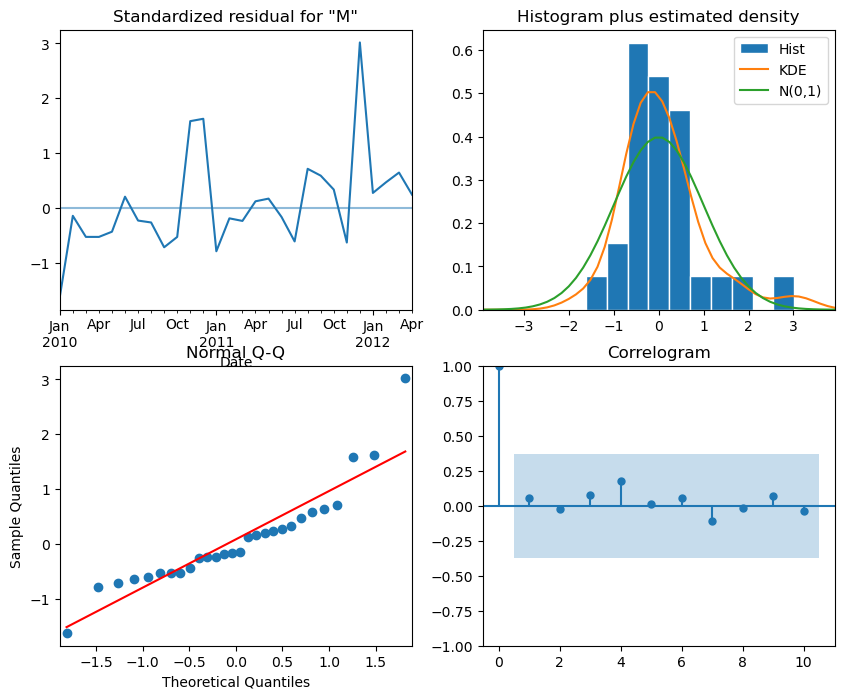

In [57]:
# with plots
mth_model_fit.plot_diagnostics(figsize=(10,8));

In [63]:
# with ljung-box statistics
# checking autocorrelation of the residuals

from statsmodels.stats.diagnostic import acorr_ljungbox

mth_residuals = mth_model_fit.resid  # generate the residuals
acorr_ljungbox(mth_residuals, np.arange(1, 11, 1))  # conducting ljung-box test with 10 lags

,lb_stat,lb_pvalue
1,0.750255,0.386395
2,0.889738,0.640908
3,0.895128,0.826603
4,1.434328,0.838207
5,1.495756,0.913559
6,1.682065,0.946497
7,2.268187,0.943519
8,2.288938,0.970848
9,2.562627,0.979152
10,3.191774,0.976544


### Model for Weekly Data

In [54]:
# define the test data for weekly model
# test dataset by 20% of the data

target_weekly_test = target_weekly.tail(len(target_weekly) - int((np.ceil(len(target_weekly) * 0.8))))
exog_weekly_test = exog_weekly.tail(len(target_weekly) - int((np.ceil(len(target_weekly) * 0.8))))

In [55]:
# fitting SARIMAX(1, 0, 3)

wk_model = SARIMAX(target_weekly_train,
                   exog_weekly_train,
                   order=(0, 0, 0),
                   seasonal_order=(1, 0, 0, 52),
                   simple_differencing=False)

wk_model_fit = wk_model.fit(disp=False)
wk_model_fit.summary()  # printing the result

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:             Weekly_Sales   No. Observations:                  114
Model:             SARIMAX(1, 0, 0, 52)   Log Likelihood               -1485.827
Date:                  Fri, 24 Mar 2023   AIC                           2983.654
Time:                          23:30:04   BIC                           3000.071
Sample:                               0   HQIC                          2990.317
                                  - 114                                         
Covariance Type:                    opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Temperature  -1300.5643    681.402     -1.909      0.056   -2636.087      34.959
Fuel_Price    -4.72e+04   3.99e+04     -1.183      0.237   -1.25e+05     3.1e+04
CPI           7484.0799   1684.003      4.444      0.000    4183.496    1.08e+04
Unemployment   291.9911   2.27e+04      0.013      0.990   -4.42e+04    4.48e+04
ar.S.L52         0.7282      0.029     24.997      0.000       0.671       0.785
sigma2        7.658e+09      0.192   3.98e+10      0.000    7.66e+09    7.66e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.68   Jarque-Bera (JB):               656.33
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               6.14   Skew:                             2.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.28e+26. Standard errors may be unstable.
"""

    Model Diagnosis

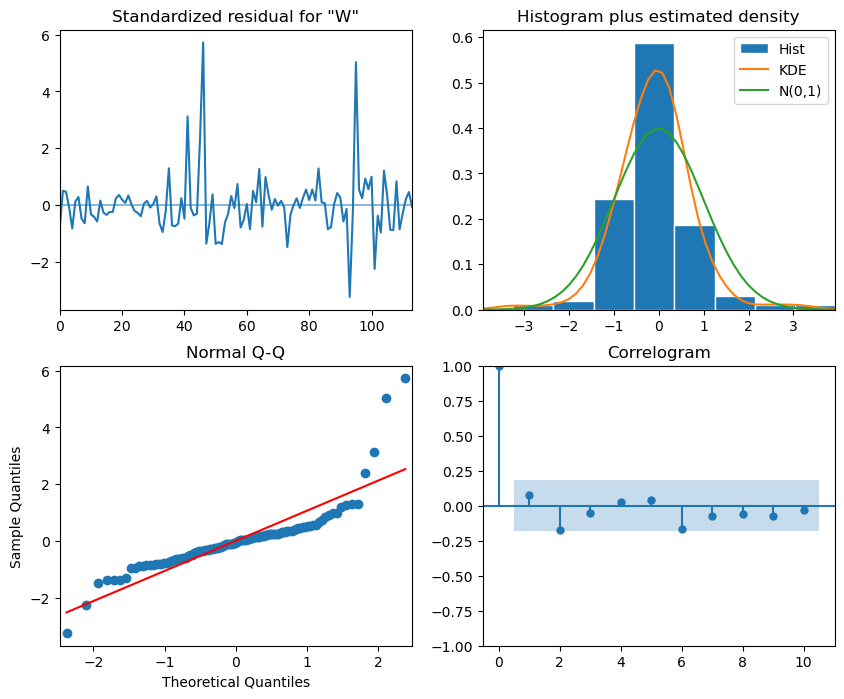

In [59]:
# with plots
wk_model_fit.plot_diagnostics(figsize=(10,8));

In [61]:
# with ljung-box statistics
# checking autocorrelation of the residuals

from statsmodels.stats.diagnostic import acorr_ljungbox

wk_residuals = wk_model_fit.resid  # generate the residuals
acorr_ljungbox(wk_residuals, np.arange(1, 11, 1))  # conducting ljung-box test with 10 lags

,lb_stat,lb_pvalue
1,0.835412,0.360712
2,4.529121,0.103876
3,4.744219,0.191514
4,4.998328,0.287469
5,5.322228,0.377833
6,8.363942,0.212634
7,8.801511,0.267223
8,9.422804,0.307893
9,11.126686,0.267125
10,11.228932,0.339963


## Step 5: Evaluating the Model

For SARIMAX model, it's not advisable to forecast time series more than 1 period ahead. Thus, we're going to use a recursive forecasting, which will forecast the time series one by one. Meaning that the forecast will predict one step ahead, and then this prediction would be used for the forecasting after that period.

### Weekly Data

In [281]:
def rolling_forecast(endog: Union[pd.Series, list],
                     exog: Union[pd.Series, list],
                     data_len: int,
                     horizon: int,                       # how many time ahead we want to predict
                     window: int,                        # steps for making the prediction
                     method: str,                        # method for forecasting, including mean, last value, and sarimax
                     **kwargs                            # kwargs for additional parameters using sarimax
                     ) -> list:                  
    
    total_len = data_len + horizon
    pred_value = []
    
    # naive forecast based on last value, as a comparison
    
    if method == 'last':

        for i in range(data_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_value.extend(last_value for _ in range(window))
    
    # naive forecast based on the mean values
    
    elif method == 'mean':
        
        for i in range(data_len, total_len, window):
            mean_value = np.mean(endog[:i].values)
            pred_value.extend(mean_value for _ in range(window))
    
    # forecast based on sarimax model
    
    elif method == 'sarimax':
        
        for i in range(data_len, total_len, window):
            model = SARIMAX(endog[:i],
                            exog[:i],
                            simple_differencing=False,
                            **kwargs)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog[:i])         # to get in- and out-of-sample prediction
            oos_pred = predictions.predicted_mean.iloc[-window:]    # get the predicted mean from the last (n) sample 
            pred_value.extend(oos_pred)
    
    return pred_value

In [238]:
# how to use the function

predict_weekly_df = pd.DataFrame()

predict_weekly_df['actual'] = target_weekly_test
predict_weekly_df['sarimax'] = rolling_forecast(target_weekly, exog_weekly, data_len=len(target_weekly_train), horizon=len(target_weekly_test), window=1, 
                                                method='sarimax', order=(0, 0, 0), seasonal_order=(1, 0, 0, 52))
predict_weekly_df['naive_last'] = rolling_forecast(target_weekly, exog_weekly, data_len=len(target_weekly_train), horizon=len(target_weekly_test), window=1, 
                                                   method='last')
predict_weekly_df['naive_mean'] = rolling_forecast(target_weekly, exog_weekly, data_len=len(target_weekly_train), horizon=len(target_weekly_test), window=1, 
                                                   method='mean')

predict_weekly_df

,actual,sarimax,naive_last,naive_mean
Date,,,,
2012-04-20,1.001612e+06,1.041810e+06,1.036206e+06,1.048076e+06
2012-04-27,9.714844e+05,1.056507e+06,1.001612e+06,1.047672e+06
2012-05-10,1.057036e+06,1.021556e+06,9.714844e+05,1.047015e+06
2012-05-18,1.040532e+06,1.092082e+06,1.057036e+06,1.047101e+06
2012-05-25,1.064277e+06,1.005661e+06,1.040532e+06,1.047045e+06
2012-06-01,9.990094e+05,1.087391e+06,1.064277e+06,1.047190e+06
2012-06-04,1.188940e+06,1.085117e+06,9.990094e+05,1.046788e+06
2012-06-07,1.138956e+06,1.022970e+06,1.188940e+06,1.047963e+06
2012-06-15,1.075825e+06,1.051387e+06,1.138956e+06,1.048709e+06


In [300]:
# merge prediction into weekly df

weekly_df = weekly_df.merge(predict_weekly_df[['sarimax', 'naive_last', 'naive_mean']],
                            how='outer', left_index=True, right_index=True)

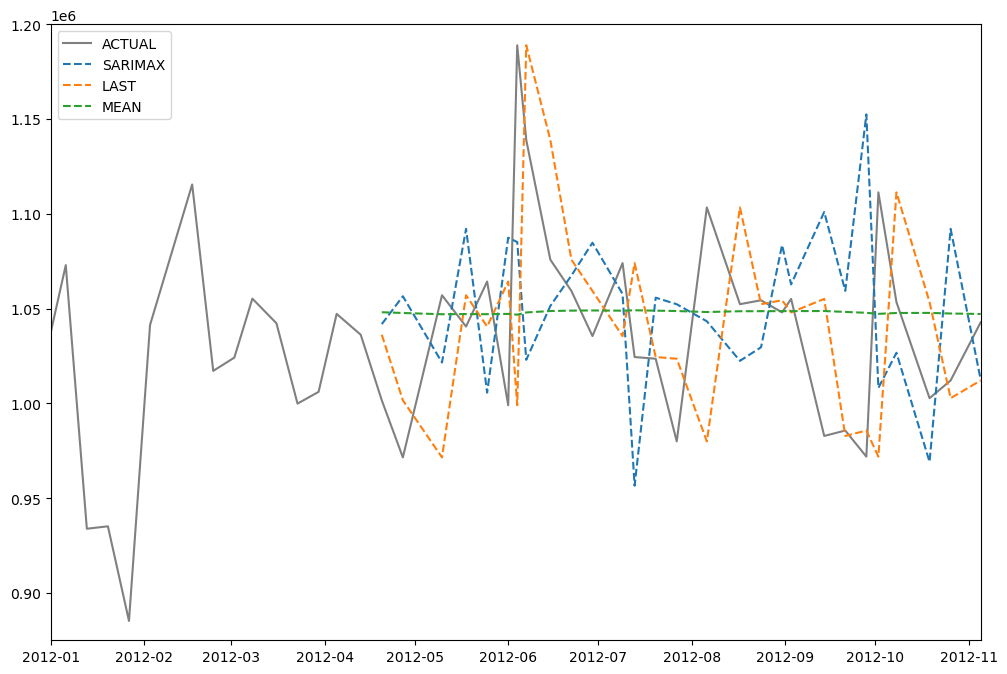

In [244]:
plt.figure(figsize=(12, 8))

plt.plot(weekly_df.index, weekly_df['Weekly_Sales'], color='gray', label="ACTUAL")
plt.plot(weekly_df.index, weekly_df['sarimax'], linestyle='dashed', label="SARIMAX")
plt.plot(weekly_df.index, weekly_df['naive_mean'], linestyle='dashed', label="MEAN")
plt.plot(weekly_df.index, weekly_df['naive_last'], linestyle='dashed', label="LAST")

# display graph

plt.legend(loc="upper left")
plt.xlim([datetime.date(2012, 1, 1), datetime.date(2012, 11, 5)])
plt.ylim([0.875 * 1e6, 1.2 * 1e6])
plt.show()

    Evaluation using MAPE Score

In [245]:
# defining the function to calculat mean absolute percentage error

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred).dropna() / y_true)) * 100

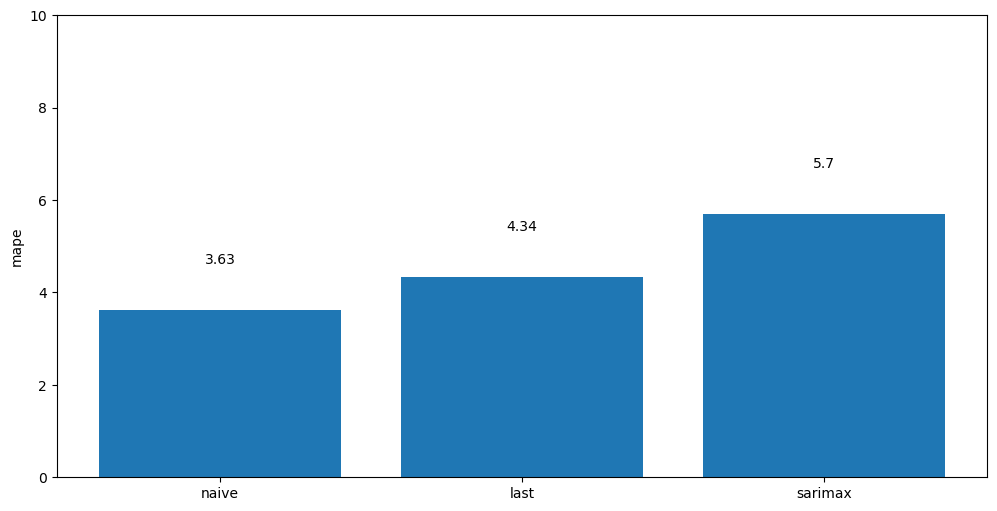

In [247]:
mape_mean = mape(weekly_df['Weekly_Sales'], weekly_df['naive_mean'])
mape_last = mape(weekly_df['Weekly_Sales'], weekly_df['naive_last'])
mape_sarimax = mape(weekly_df['Weekly_Sales'], weekly_df['sarimax'])

# plot all the variable

fig, ax = plt.subplots(figsize=(12,6))

x = ['naive', 'last', 'sarimax']
y = [mape_mean, mape_last, mape_sarimax]

ax.bar(x, y, width=0.8)
ax.set_ylim(0,10)
ax.set_ylabel('mape')

# adding data point to the plot

for i, val in enumerate(y):
    plt.text(x=i, y=val + 1, s=str(round(val, 2)), ha='center')

### Monthly Data

In [306]:
# how to use the function

predict_monthly_df = pd.DataFrame()

predict_monthly_df['actual'] = target_month_test
predict_monthly_df['sarimax'] = rolling_forecast(target_month, exog_month, data_len=len(target_month_train), horizon=len(target_month_test), window=1, 
                                                 method='sarimax', order=(0, 0, 0), seasonal_order=(1, 0, 0, 12))
predict_monthly_df['naive_last'] = rolling_forecast(target_month, exog_month, data_len=len(target_month_train), horizon=len(target_month_test), window=1, 
                                                    method='last')
predict_monthly_df['naive_mean'] = rolling_forecast(target_month, exog_month, data_len=len(target_month_train), horizon=len(target_month_test), window=1, 
                                                    method='mean')

predict_monthly_df

,actual,sarimax,naive_last,naive_mean
Date,,,,
2012-05-31,1.053948e+06,1.004114e+06,1.014127e+06,1.043938e+06
2012-06-30,1.082920e+06,1.014796e+06,1.053948e+06,1.044283e+06
2012-07-31,1.025480e+06,1.056945e+06,1.082920e+06,1.045571e+06
2012-08-31,1.064514e+06,1.007118e+06,1.025480e+06,1.044923e+06
2012-09-30,9.988663e+05,1.058503e+06,1.064514e+06,1.045535e+06
2012-10-31,1.044885e+06,1.030311e+06,9.988663e+05,1.044121e+06
2012-11-30,1.042797e+06,1.031290e+06,1.044885e+06,1.044143e+06


In [307]:
# merge prediction into weekly df
# into one df

monthly_df = monthly_df.merge(predict_monthly_df[['sarimax', 'naive_last', 'naive_mean']],
                              how='outer', left_index=True, right_index=True)

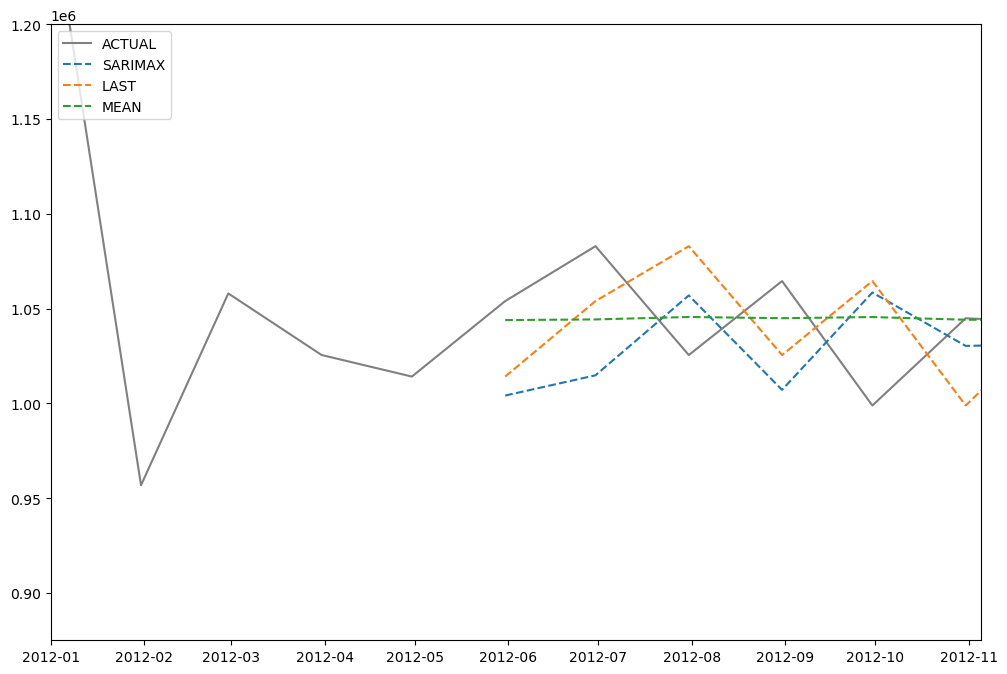

In [308]:
plt.figure(figsize=(12, 8))

plt.plot(monthly_df.index, monthly_df['Monthly_Sales'], color='gray', label="ACTUAL")
plt.plot(monthly_df.index, monthly_df['sarimax'], linestyle='dashed', label="SARIMAX")
plt.plot(monthly_df.index, monthly_df['naive_last'], linestyle='dashed', label="LAST")
plt.plot(monthly_df.index, monthly_df['naive_mean'], linestyle='dashed', label="MEAN")
 
# display graph

plt.legend(loc="upper left")
plt.xlim([datetime.date(2012, 1, 1), datetime.date(2012, 11, 5)])
plt.ylim([0.875 * 1e6, 1.2 * 1e6])
plt.show()

    Evaluation using MAPE Score

In [309]:
# defining the function to calculat mean absolute percentage error

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred).dropna() / y_true)) * 100

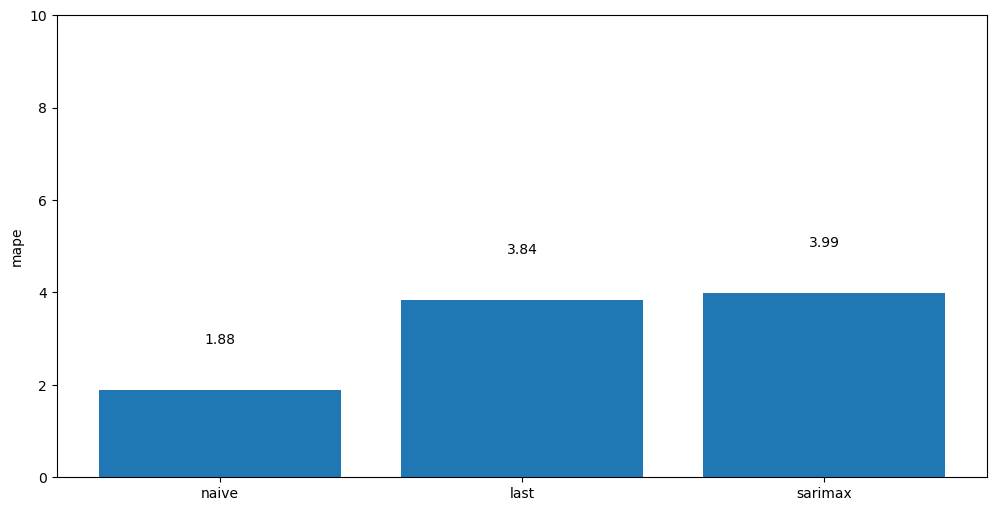

In [310]:
mape_mean = mape(monthly_df['Monthly_Sales'], monthly_df['naive_mean'])
mape_last = mape(monthly_df['Monthly_Sales'], monthly_df['naive_last'])
mape_sarimax = mape(monthly_df['Monthly_Sales'], monthly_df['sarimax'])

# plot all the variable

fig, ax = plt.subplots(figsize=(12,6))

x = ['naive', 'last', 'sarimax']
y = [mape_mean, mape_last, mape_sarimax]

ax.bar(x, y, width=0.8)
ax.set_ylim(0,10)
ax.set_ylabel('mape')

# adding data point to the plot

for i, val in enumerate(y):
    plt.text(x=i, y=val + 1, s=str(round(val, 2)), ha='center')